# Spatial Transformers

## Imports

In [10]:
# ----- Tensorflow -----
import tensorflow as tf
from keras import regularizers as reg
from keras import optimizers
from keras.layers import Input, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, AveragePooling2D, Rescaling, BatchNormalization, Activation, SpatialDropout2D

# ----- Model saving -----
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint


# ----- Plotting -----
import matplotlib.pyplot as plt
from utils import plot_hist

# ----- Data -----
from utils import load_data, preprocess_data, is_cancer

# ----- Spatial transformers -----
from spatial_transformer import create_spatial_transformer, get_localizer

## Load Data

In [11]:
data_dir = r'C:\Users\andly'
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=5, batch_size=BATCH_SIZE)

def do_nothing(x):
    return x

x_val, y_val = preprocess_data(val, do_nothing)



## Final CNN with spatial transformers

In [12]:
Best_optimizer = optimizers.Nadam(learning_rate=0.0001)
Best_penalty = 0.001
Best_dropout = 0.2

In [13]:
# ----- INPUT -----
inputs = Input(shape=(96, 96, 3))

# ----- SPATIAL TRANSFORMER -----
x = create_spatial_transformer(input_shape=(96,96,3))(inputs)

# ----- CNN MODEL -----
# ----- SIMPLE CNN + L2 REGULARIZATION + DROPOUT(0.2) -----
x = Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=64, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = SpatialDropout2D(Best_dropout)(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=128, kernel_size=3, activation="relu", kernel_regularizer=reg.L2(Best_penalty))(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(Best_penalty))(x)
x = SpatialDropout2D(Best_dropout)(x)
x = MaxPooling2D(pool_size=2)(x)

x = Conv2D(filters=256, kernel_size=3, activation="relu", kernel_regularizer=reg.L1(Best_penalty))(x)

# ----- CLASSIFIER -----
x = Flatten()(x)
outputs = Dense(2, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)




Building Localization Network with input shape: (None, 96, 96, 3)
Building Bilinear Interpolation Layer with input shape: [TensorShape([None, 96, 96, 3]), TensorShape([None, 2, 3])]


### Hyperparameters

In [14]:

OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=0.0001)
EPOCHS = 100



### Compile model

In [15]:
# ----- Configure model -----
model.compile(optimizer=OPTIMIZER,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

            

### Train model

In [16]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 model_2 (Functional)        (None, 96, 96, 3)         188086    
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 64)        18496     
                                                                 
 spatial_dropout2d_2 (Spatia  (None, 45, 45, 64)       0         
 lDropout2D)                                               

In [17]:
# ----- Train model -----
history = model.fit(train,
					epochs=EPOCHS,
					validation_data=val)


                    

Epoch 1/100
410/410 [==============================] - 26s 57ms/step - loss: 6.6639 - accuracy: 0.6654 - val_loss: 1.0968 - val_accuracy: 0.7601
Epoch 2/100
410/410 [==============================] - 23s 56ms/step - loss: 0.8457 - accuracy: 0.7433 - val_loss: 0.6995 - val_accuracy: 0.7582
Epoch 3/100
410/410 [==============================] - 23s 56ms/step - loss: 0.6833 - accuracy: 0.7514 - val_loss: 0.6325 - val_accuracy: 0.7601
Epoch 4/100
410/410 [==============================] - 23s 56ms/step - loss: 0.6404 - accuracy: 0.7586 - val_loss: 0.6077 - val_accuracy: 0.7601
Epoch 5/100
410/410 [==============================] - 23s 57ms/step - loss: 0.6198 - accuracy: 0.7632 - val_loss: 0.5979 - val_accuracy: 0.7619
Epoch 6/100
410/410 [==============================] - 22s 55ms/step - loss: 0.6047 - accuracy: 0.7694 - val_loss: 0.5934 - val_accuracy: 0.7607
Epoch 7/100
410/410 [==============================] - 22s 55ms/step - loss: 0.5938 - accuracy: 0.7747 - val_loss: 0.5785 - val_ac

### Plot results

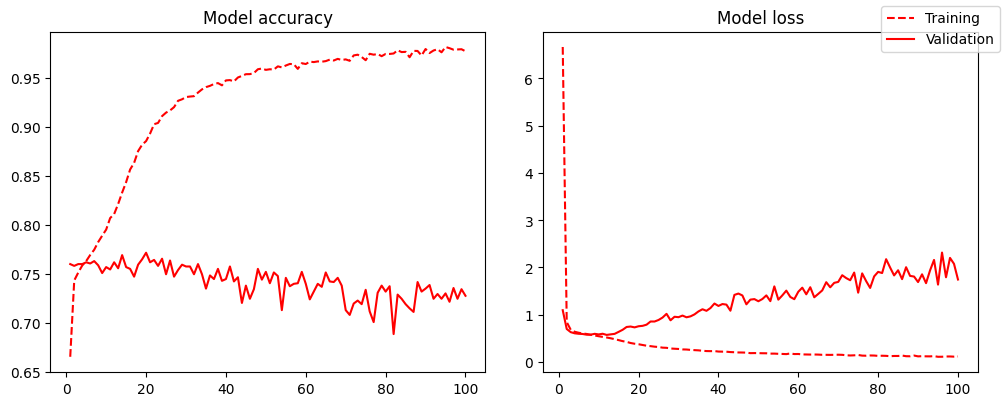

In [22]:
plot_hist(history)




### Evaluate model

In [23]:
model.evaluate(test)




52/52 [==============================] - 2s 28ms/step - loss: 1.4694 - accuracy: 0.7350


[1.4694335460662842, 0.7350427508354187]

## Plot spatial transformer output

#### Plot original image

Text(0.5, 1.0, 'Original Image')

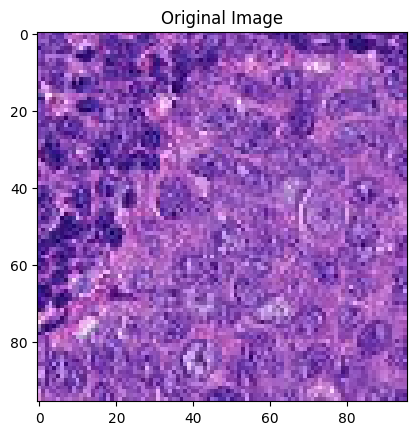

In [29]:
index = 10
img = x_val[index]
plt.imshow(img)
plt.title('Original Image')

#### Plot restored image

52/52 [==============================] - 2s 29ms/step


Text(0.5, 1.0, 'Restored Image')

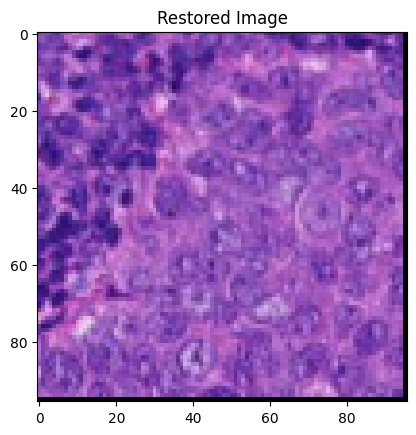

In [30]:
transformer = model.get_layer('model_2')
preds = transformer.predict(x_val)
plt.imshow(preds[index])
plt.title('Restored Image')


#### Plot Latent space

52/52 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'Latent space')

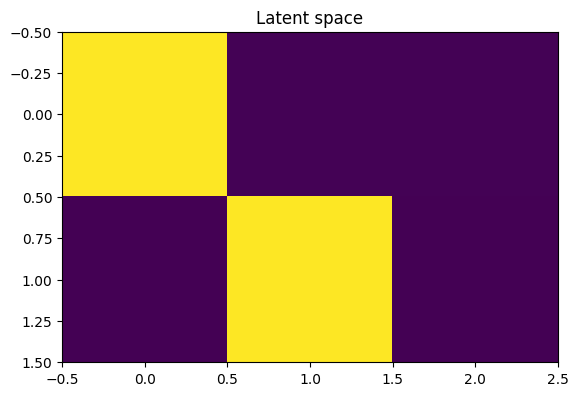

In [31]:
localizer = get_localizer(transformer)
latent_imgs = localizer.predict(x_val)
plt.imshow(latent_imgs[index])
plt.title("Latent space")

#### Activation maps: Heatmap

In [36]:
# New function
def get_heatmap(category, start_image):
    cell_output     = model.get_layer('dense_5').output # output layer
    last_conv_layer = model.get_layer('conv2d_13').output # deep convolution 
                                                         # we could use something else
    submodel = tf.keras.models.Model([model.inputs], [cell_output, last_conv_layer])

    input_img_data = start_image.copy()
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    with tf.GradientTape() as tape:
        outputs_class, outputs_conv = submodel(input_img_data)
        loss_value                  = tf.reduce_mean(outputs_class[:, category])

    grads = tape.gradient(loss_value, outputs_conv)

    cast_outputs_conv = tf.cast(outputs_conv > 0, "float32")
    cast_grads        = tf.cast(grads > 0, "float32")
    guided_grads      = cast_outputs_conv * cast_grads * grads
    outputs_conv      = outputs_conv[0]
    guided_grads      = guided_grads[0]
    
    weights           = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam               = tf.reduce_sum(tf.multiply(weights, outputs_conv), axis=-1)
    
    return cam
    

#### Get sick cells

In [37]:
from utils import is_cancer

for images, labels in train.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

numpy_images_2 = []
numpy_labels_2 = []

# Get cancer cells
for label, image in zip(numpy_labels, numpy_images):
    if is_cancer(label): # If true (cancer)
        numpy_images_2.append(image)
        numpy_labels_2.append(1)

#### Create heatmap

In [38]:
from PIL import Image
cmap = plt.get_cmap('jet')

def create_heatmap(idx):
    category, image = numpy_labels_2[idx], numpy_images[idx:(idx + 1)]

    heatmap = get_heatmap(category, image)
    heatmap = heatmap.numpy()
    heatmap = Image.fromarray(heatmap)
    heatmap = heatmap.resize((96, 96), Image.ANTIALIAS)
    #heatmap = heatmap.resize((32, 32), Image.LANCZOS)# 
    heatmap = np.array(heatmap) # back to numpy array
    heatmap = (heatmap / heatmap.max()) # to [0, 1]    
    heatmap = cmap(heatmap)
    heatmap = np.delete(heatmap, 3, 2)

    overlayed_heatmap = 0.6 * image[0] + 0.4 * heatmap
    
    return image[0], heatmap, overlayed_heatmap

def plot_heatmap():
    plt.figure(figsize=(10, 10))
    for i in range(3):
        images = create_heatmap(i)
        for j in range(3):
            ax = plt.subplot(3, 3, i * 3 + 1 + j); plt.axis('off'); plt.imshow(images[j])
    plt.show()

#### Display heatmap

C:\Users\andly\AppData\Local\Temp\ipykernel_19464\1761033284.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  heatmap = heatmap.resize((96, 96), Image.ANTIALIAS)


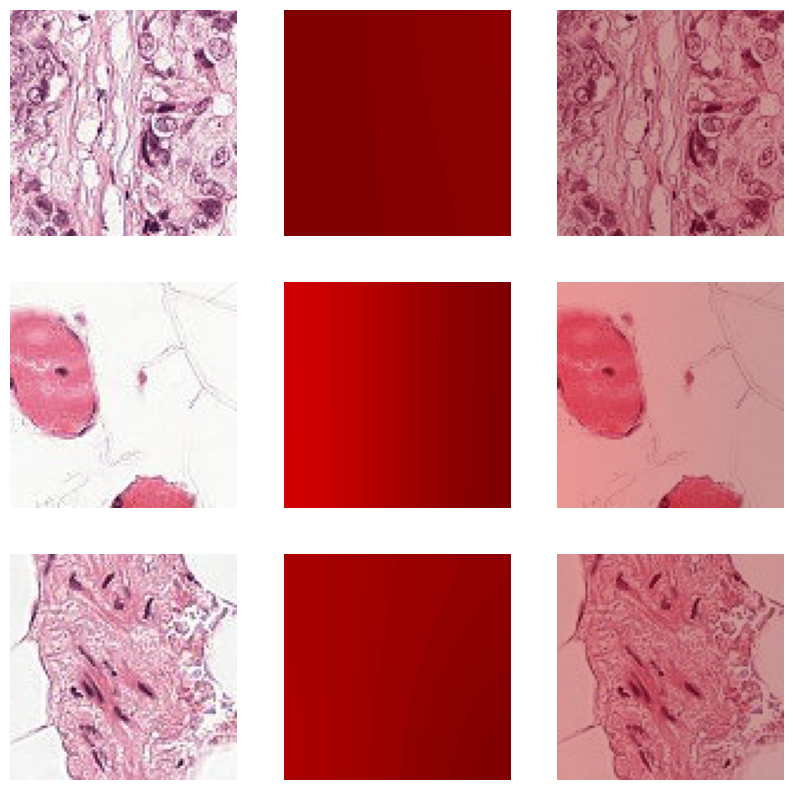

In [40]:
import numpy as np
plot_heatmap()